In [1]:
using Pkg

Pkg.activate("..")

using MiCRM_stability
using Distributions,LinearAlgebra,StatsBase, Distances
using CairoMakie
using DelimitedFiles
using Random
using Graphs, GraphMakie, NetworkLayout, SimpleWeightedGraphs

  Activating project at `~/Projects/Working/HIFMB/MiCRM_stability`


# Introduction

In this notebook I will look at the various factors determining stabiltiy in the generalised microbial model

In [2]:
function get_param_mean(p::MiCRM_stability.Parameters)
    fe = fieldnames(MiCRM_stability.exponential_params)
    fs = fieldnames(MiCRM_stability.structural_params)

    ue = mean.(getfield.(Ref(p.e), fe))
    us = mean.(getfield.(Ref(p.s), fs))

    vcat(ue...,us...) 
end

function get_real(x::T) where T <: AbstractFloat
    x
end

get_real(x::Complex) = x.re

Revise.revise()

In [3]:
function get_A(com)
    N,M = com.N, com.M
    A = zeros(N+M, N+M)
    
    for i = 1:N
        for j = 1:M
            A[N + j, i] = com.U[i,j]
            A[i, N + j] = com.L[i,j]
        end
    end
    
    return(A)
end
    
function check_connected(com)
    A = get_A(com)
    A = (A + A')
    B = diagm(sum(A, dims = 2)[:]) - A

    return(sum(abs.(eigen(B).values) .< 1e-10) == 1)
end

check_connected (generic function with 1 method)

In [4]:
function rand_com(N,M,C)
    ci = rand(N)
    ci = ci[sortperm(sum.(ci))]
    
    ca = rand(M)
    ca = ca[sortperm(sum.(ca))]
    
    d = ci .- ca'
    
    fu(x, dist) = dist > x >= 0 ? rand() : 0
    fl(x, dist) = -dist < x < 0 ? rand() : 0
    
    U = zeros(N,M)
    L = zeros(N,M)

    # V = 0.01
    # a = (((1-C) / V) - (1/C)) * C^2
    # b = a * (1/C - 1)

    b = (1/C - 1)
    dβ = Beta(1, b)

    for i = 1:N
        ind = findmin(abs.(d[i,:]))[2]
        x = d[i,:] .- d[i,ind]
        U[i,:] .= fu.(x, rand(dβ))
        L[i,:] .= fl.(x, rand(dβ))
    end

    U[:,end] .= 0.0
    L[:,1] .= 0.0
    
    return(MiCRM_stability.Community(N,M,U,L))
end

function shuffle!(com)
    U,L = com.U, com.L
    N,M = com.N, com.M
    
    #shuffle pairs
    p1 = (rand(1:N),rand(1:M))
    p2 = (rand(1:N),rand(1:M))
    a = rand()
    
    if a < 0.5
        tmp = deepcopy(U[p1...])
        U[p1...] = U[p2...]
        U[p2...] = tmp
    else
        tmp = deepcopy(L[p1...])
        L[p1...] = U[p2...]
        L[p2...] = tmp
    end
end

shuffle! (generic function with 1 method)

In [5]:
N = 20
M = 100
a = rand_com(N,M, 0.3)
while !check_connected(a)
    a = rand_com(N,M, 0.3)
end

In [6]:
check_connected(a)

true

In [7]:

A = get_A(a)
tl = TL(A)
c = vcat(fill(:red,N),fill(:blue,M))
c[sum(A, dims = 1)[:] .== 0] .= :green
c[sum(A, dims = 2)[:] .== 0] .= :orange

c = [(v, 0.9 + 0.1*(tl[i] / maximum(tl)) ) for (i,v) = enumerate(c)]
    # ns = TL(A') 
    # ns = 5 .+ 5(ns ./ maximum(ns))
# ns = ones(size(A)[1])
    
g = SimpleWeightedDiGraph(A)
ec = [(:black, i.weight) for i = collect(edges(g))]
layout = Spring()#mylayout(g, N, M, A)
f,ax = graphplot(g, layout = layout, node_color = c, edge_color = ec)
heatmap!(Axis(f[1,2]), A)
f

LoadError: UndefVarError: `TL` not defined

In [8]:
function TL(A)
    N = size(A)[1]
    B = similar(A)
    for i = 1:N
        if sum(A[i,:]) > 0
            B[i,:] = A[i,:] ./ sum(A[i,:])
        end
    end
    
    return inv(I(N) - A) * ones(N)
end
    

function mylayout(g, N, M, A)
   xs = vcat(fill(1, N), fill(2, M)) .+ 0.01randn(N+M)
   ys = TL(A)

    return Point.(zip(xs, ys))
end


function plot_com!(com, ax)
    A = get_A(com)
    c = vcat(fill(:red,com.N),fill(:blue,com.M))
    c[com.N+1] = :green
    c[end] = :green

    ns = 10ones(com.N + com.M)
    
    g = SimpleWeightedDiGraph(A)
    ec = [(:black, i.weight) for i = collect(edges(g))]
    layout = Spring()#mylayout(g, N, M, A)
    graphplot!(ax, g, layout = layout, node_color = c, node_size = ns, edge_color = ec)
end

plot_com! (generic function with 1 method)

In [9]:
Random.seed!(1)
N,M = 20,30
C = 0.1
σ = [1.0, 0.0, 0.0, 0.0, 0.0]
# com = MiCRM_stability.correlated_rand_model(N,M,σ, C, C)
com = rand_com(N,M, 0.2)
com_o = deepcopy(com)
A = check_connected(com)

true

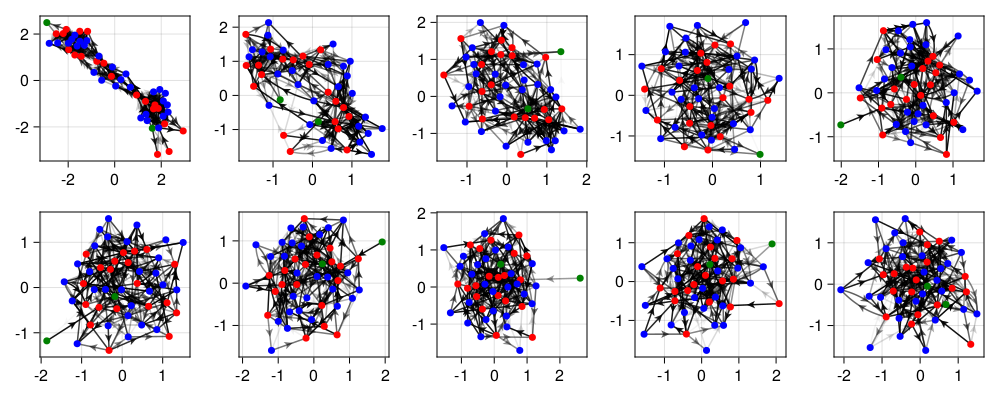

In [10]:
f = Figure(resolution = (1000, 400))
ax = hcat([[Axis(f[j,i]) for i = 1:5] for j = 1:2]...)

for i = 1:10
    plot_com!(com, ax[i])
    [shuffle!(com) for i = 1:(100)]
end
f

In [11]:
Random.seed!(1)
N,M = 50,100
C = 0.1
σ = [1.0, 0.0, 0.0, 0.0, 0.0]
# com = MiCRM_stability.correlated_rand_model(N,M,σ, C, C)
com = rand_com(N,M, 0.2)
A = check_connected(com)
println(A)

Ns = 301
ut = zeros(Ns)
d = zeros(Ns)

for i = 1:Ns
    shuffle!(com)
    A = get_A(com)
    
    try
        ind = TL(A) |> sortperm
        A = get_A(com)
        ut[i] = sum(LowerTriangular(A[ind,ind])) / sum(A)
    catch
        ut[i] = 0
    end

    g = SimpleWeightedDiGraph(A)
    src = filter(x -> x > N, findall(indegree(g) .== 0))
    snk = filter(x -> x > N, findall(outdegree(g) .== 0))
    d[i] = Graphs.gdistances(g, src)[snk] |> mean
    
end

true


# Dynamic Parameters

First we look at the effects of the dynamic/exponetial parameters in the model. Here I simulate 10000 systems with different parameter values which we can then correlate with the stability metrics

In [27]:
function get_exponential_parameters(N,M)
    σ = 0.1
    gx = rand(Uniform(0.0, 1.0)) .+ zeros(N)
    gs = rand(Uniform(0,3)) .+ rand(Uniform(-σ,σ), N)
    gw = -rand(Uniform(0,5)) .+ rand(Uniform(-σ,σ), N)
    mx = rand(Uniform(0, 1.0)) .+ zeros(N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)


    iy = rand(Uniform(0.0,1.0)) .+ rand(Uniform(-σ,σ), M)
    oy = rand(Uniform(1,2)) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [29]:
N,M = 20,40
Ncom = 10000
Nrep = 1

J_stab = 0
c_stab = 0
c = 0

k = [0]

λ_mat = zeros(Ncom, Nrep)
r_mat = zeros(Ncom, Nrep)
p_mat = Array{Float64,3}(undef, Ncom, Nrep,29)
s_mat = Array{Tuple,2}(undef, Ncom, Nrep)
c_mat = Array{MiCRM_stability.Community, 1}(undef, Ncom)
p = 0

Threads.@threads for i = 1:Ncom

    # N = 50 #rand(1:100)
    # M = 50 #rand(1:100)
    
    k[1] += 1
    if k[1] % 100 == 0
        print("\r", k)
    end
    f = true
    c = 0
    while f
        # c = rand_com(N,M, 0.25)
        # c.U .= c.U .* rand(N,M)
        # c.L .= c.L .* rand(N,M)
        
        σ = [1.0, 0.0, 0.0, 0.0, 0.0]
       
        C = rand() / 2
        # c = MiCRM_stability.correlated_rand_model(N,M, σ, C, C)
        c = rand_com(N,M,C)
        
        f = !check_connected(c)
    end
    
    c_mat[i] = deepcopy(c)
    J = zeros(c.N+c.M,c.N+c.M)
    H = zeros(c.N+c.M,c.N+c.M)
    
    Ns = rand(1:10000)
    # [shuffle!(c.U, c.L) for i = 1:Ns]
    
    d = rand()
    s_vec = [mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.U))), 
             mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.L))),
            N,M,mean(c.U),N/M, d, Ns, 0]
    
    for j = 1:Nrep
        sp = MiCRM_stability.get_structural_params(c.U, c.L, c.N, c.M)
        ep = get_exponential_parameters(c.N, c.M)
        p = MiCRM_stability.Parameters(c.N,c.M,sp,ep)
        
        s_vec[end] = mean(p.e.ωy ./ (p.e.λy .+ p.e.ωy))
        
        MiCRM_stability.jacobian!(p, J)
        λ_mat[i,j] = get_real(eigvals(J)[end])

        if λ_mat[i,j] < 0
            global J_stab = deepcopy(J)
            global c_stab = deepcopy(c)
        end

        H = Hermitian(J)
        r_mat[i,j] = eigvals(H)[end]
        
        p_mat[i,j,:] .= vcat(get_param_mean(p), s_vec)
    end
end

println("\n", sum([l < 1e-5 for l = λ_mat[:]]) )

[9901]
1198


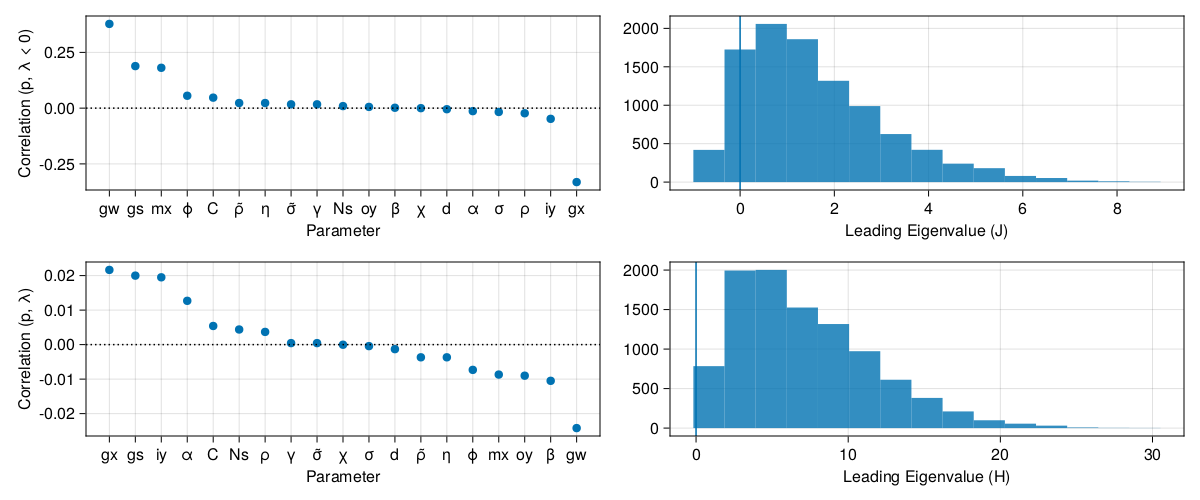

In [30]:
fe = fieldnames(MiCRM_stability.exponential_params)
fs = fieldnames(MiCRM_stability.structural_params)

f = Figure(resolution = (1200,500))

#stability correlation
stab = (λ_mat .< -1e-5)[:,1]
cor_vec = [cor(stab, p_mat[:,1,p]) for p = 1:29]
s_ind = sortperm(cor_vec, rev=true)
ax2 = Axis(f[1,1], xlabel = "Parameter", ylabel = "Correlation (p, λ < 0)",
    xticks = (1:29, string.(vcat([fe...,fs...,"U","L","N","M","C","N/M","d","Ns","Λ"]...))[s_ind]))
scatter!(ax2, cor_vec[s_ind])
hlines!(ax2, [0.0], linestyle = :dot, color = :black)


#return time correlation
reac = (r_mat .> 1e-5)[:,1]
cor_vec = [cor(reac, p_mat[:,1,p]) for p = 1:29]
s_ind = sortperm(cor_vec, rev=true)

ax2 = Axis(f[2,1], xlabel = "Parameter", ylabel = "Correlation (p, λ)",
    xticks = (1:29, string.(vcat([fe...,fs...,"U","L","N","M","C","N/M","d","Ns","Λ"]...))[s_ind]))

scatter!(ax2, cor_vec[s_ind])
hlines!(ax2, [0.0], linestyle = :dot, color = :black)

#histograms
ax1 = Axis(f[1,2], xlabel = "Leading Eigenvalue (J)")
hist!(ax1, Real.(λ_mat)[:])
vlines!(ax1, [0.0])

ax1 = Axis(f[2, 2], xlabel = "Leading Eigenvalue (H)")
hist!(ax1, Real.(r_mat)[:])
vlines!(ax1, [0.0])

f

Overal the Here we can see the effect of the various parameters. 

Positively affecting stability are the sensitvtiy of contributions f_{ia}^{(y)}, the sensitvity of uptake to substrate ammount $g_{i}^{(s)}$, the sesitvtiy of consumer mortality $m_i^{x}$ and the sensitvity of resource outflow $o_{a}^{y}$.

Negatively affecting stabiltiy is the sensitvity of leakage proportion to resource abundance $\lambda_i^{(y)}$, the sensitvity of uptake to waste and consumer abundance $g_{i}^{(w)}, g_{i}^{(x)}$ as well as the sensitvtiy of resource inflow $i_a^{(y)}$

These results make sense and suggest two mechanisms for stability. 

First is the self-inhibition through which consumers and resources are naturaly stable due to the self-dynamics. This is seen in the stabilising effects of the mortality and loss terms $m_i^{(x)}$ and $o_a^{(y)}$ the destabilising effects of the sensitity of uptake and resource inflow $g_{i}^{(x)}$ and $i_a^{(y)}$. These terms all appear in the diagonal elements of the Jacobian and thus promote stability by reducing their values (thus shifting all eigenvalues towards negative values). 

Second is the capacity of consumers to respond to resource perturbations, shown in the sensitivtiy of uptake to substrates and waste products $g_{i}^{(s)},g_{i}^{(w)}$ which stabilise and destabilise respectively. This suggests an additional mechanism of stabilisation which depends on the abiltiy of consumers to quickly respond to changes in resource concentration. Waste product inhibition prevents this here and is thus a destabiltiying force. This is further supported by the switching terms $f_{ia}^{(y)}$ and $h_{ia}^{(y)}$ which determine the sensitvtiy with which consumers switch their uptake profiles based on resource abundance.

### structure 
is there a signature of structure?

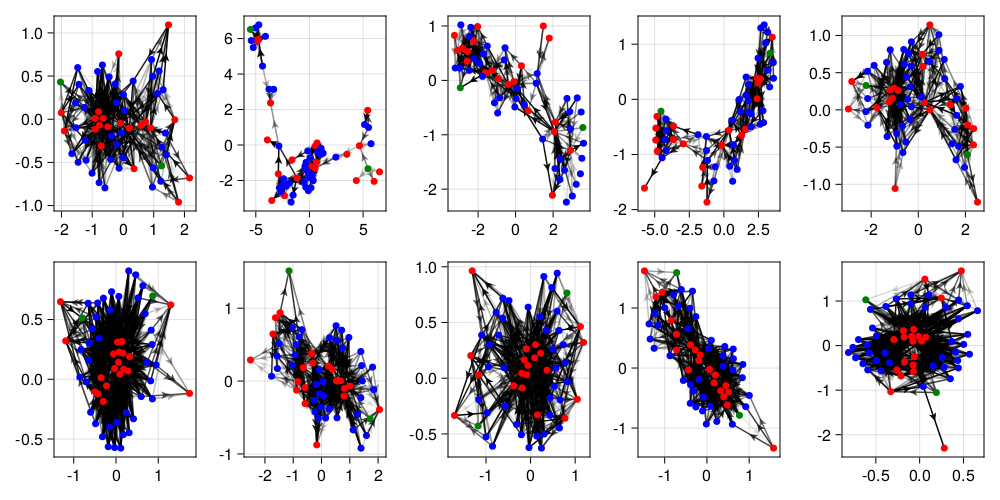

In [31]:
f = Figure(resolution = (1000,500))
ind = (λ_mat .> 0)[:] |> findall

ind = sortperm(p_mat[:,1,25])[Int.(floor.(range(1,Ncom,length = 10)))]
ax = [Axis(f[(i-1) ÷ 5,1 + i % 5]) for i = eachindex(ind)]
[plot_com!(c_mat[ind[i]], ax[i]) for i = eachindex(ind)]
f

In [1199]:
function mean_path(c)
    A = get_A(c)
    # snk = filter(x -> x > c.N , findall(sum(A, dims = 2)[:] .== 0))
    # src = filter(x -> x > c.N , findall(sum(A, dims = 1)[:] .== 0))

    src = [c.N + 1]
    snk = [c.N + c.M]
    
    g = SimpleWeightedDiGraph(A)

    B = zeros(length(src), length(snk))

    for i = eachindex(src)
        for j = eachindex(snk)
            B[i,j] = Graphs.a_star(g, src[i], snk[j]) |> length
        end
    end
    
    return mean(B)
end

mean_path (generic function with 1 method)

In [1200]:
mp = mean_path.(c_mat)
corspearman(mp, λ_mat[:] .< 0)

-0.0060957006020573475

In [1201]:
p = zeros(length(c_mat))

for i = eachindex(c_mat)
    A = get_A(c_mat[i])
    tl_ind = TL(A) |> sortperm
    p[i] = sum(UpperTriangular(A[tl_ind, tl_ind])) / sum(A)
end

In [1202]:
corspearman(p, λ_mat[:])

0.008499717252997172

In [10]:
save("../Results/Figures/stability_correlations.png", f)

CairoMakie.Screen{IMAGE}


## Switching Parameters

In [1400]:
function get_exponential_parameters(N,M)
    σ = 0.05
    gx = ones(N)
    gs = 2ones(N) .+ rand(Uniform(-σ,σ), N)
    gw = -ones(N) .+ rand(Uniform(-σ,σ), N)
    mx = 1.1ones(N) .+ zeros(N)
    
    fy = rand(Uniform(0,1)) .+ rand(Uniform(-σ,σ),N,M)
    hy = rand(Uniform(-1,0)) .+ rand(Uniform(-σ,σ),N,M)
    
    λy = rand(Uniform(-1,0.0)) .+ rand(Uniform(-σ,σ),N,M)
    ωy = rand(Uniform(0,1)) .+ rand(Uniform(-σ,σ),N,M)

    iy = zeros(M) #.+ rand(Uniform(-σ,σ), M)
    oy = ones(M)  #.+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [1401]:
N,M = 25,50
Ncom = 5000
Nrep = 1

J_stab = 0
c_stab = 0
c = 0

k = [0]

λ_mat = zeros(Ncom, Nrep)
r_mat = zeros(Ncom, Nrep)
p_mat = Array{Float64,3}(undef, Ncom, Nrep,27)
s_mat = Array{Tuple,2}(undef, Ncom, Nrep)
p = 0

Threads.@threads for i = 1:Ncom
    C = 1.0
    # N = 50 #rand(1:100)
    # M = 50 #rand(1:100)
    
    k[1] += 1
    if k[1] % 100 == 0
        print("\r", k)
    end
    J = zeros(N+M,N+M)
    H = zeros(N+M,N+M)
    
    # c = MiCRM_stability.niche_model(N,M,1,0.1)
    σ = [1.0, 0.0, 0.0, 0.0, 0.0]
    
    f = true
    c = 0
    while f
        σ = [1.0, 0.0, 0.0, 0.0, 0.0]
        C = 0.3
        # c = MiCRM_stability.correlated_rand_model(N,M, σ, C, C)
        c = rand_com(N,M,C)

        f = !check_connected(c)
    end
        
    s_vec = [mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.U))), 
             mean(pairwise(Jaccard(), eachcol(c.U), eachcol(c.L))),
            N,M,mean(c.U),N/M, 0]
    
    for j = 1:Nrep
        sp = MiCRM_stability.get_structural_params(c.U, c.L, c.N, c.M)
        ep = get_exponential_parameters(c.N, c.M)
        p = MiCRM_stability.Parameters(N,M,sp,ep)
        
        s_vec[end] = mean(p.e.ωy ./ (p.e.λy .+ p.e.ωy))
        
        MiCRM_stability.jacobian!(p, J)
        λ_mat[i,j] = get_real(eigvals(J)[end])

        if λ_mat[i,j] < 0
            global J_stab = deepcopy(J)
            global c_stab = deepcopy(c)
        end

        H = Hermitian(J)
        r_mat[i,j] = eigvals(H)[end]
        
        p_mat[i,j,:] .= vcat(get_param_mean(p), s_vec)
    end
end

println("\n", sum([l < 1e-5 for l = λ_mat[:]]) )

[4900]
935


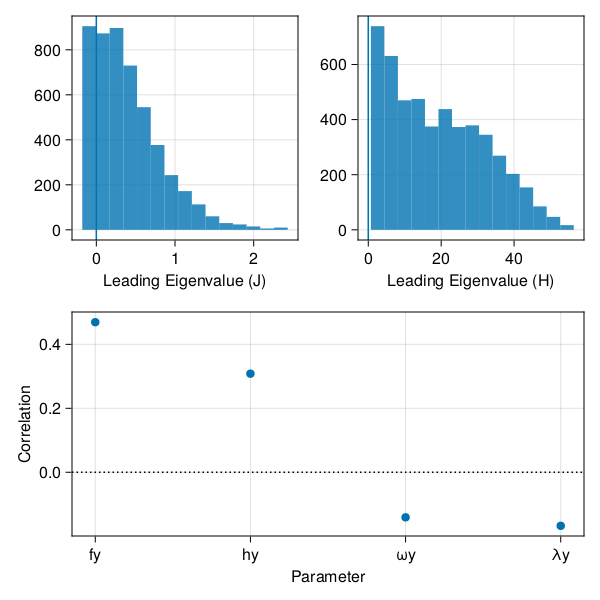

In [1402]:
fe = fieldnames(MiCRM_stability.exponential_params)

#bootstrap CI
Nsamp = 1
stab = λ_mat[:] .< -1e-5
cor_samples = zeros(size(p_mat, 3), Nsamp)

for i = axes(p_mat, 3)
    for j = 1:Nsamp
        cor_samples[i,j] = corspearman(p_mat[:,1,i], stab)
    end
end

ind = 5:8

ρ_μ = mean(cor_samples, dims = 2)[ind]
ρ_lb = mapslices(x -> isnan(x[1]) ? NaN : quantile(x, 0.05), cor_samples, dims = 2)[ind] .- ρ_μ
ρ_ub = ρ_μ .- mapslices(x -> isnan(x[1]) ? NaN : quantile(x, 0.95), cor_samples, dims = 2)[ind]

s_ind = sortperm(ρ_μ, rev=true)

f = Figure(resolution = (600,600))

ax1 = Axis(f[1,1], xlabel = "Leading Eigenvalue (J)")
hist!(ax1, Real.(λ_mat)[:])
vlines!(ax1, [0.0])

ax1 = Axis(f[1,2], xlabel = "Leading Eigenvalue (H)")
hist!(ax1, Real.(r_mat)[:])
vlines!(ax1, [0.0])

ax2 = Axis(f[2,1:2], xlabel = "Parameter", ylabel = "Correlation",
    xticks = (1:4, hcat(string.(fe)[ind][s_ind]...)[:] ))

scatter!(ax2, ρ_μ[s_ind])
errorbars!(ax2, 1:4, ρ_μ[s_ind], ρ_lb[s_ind], ρ_ub[s_ind])
hlines!(ax2, [0.0], linestyle = :dot, color = :black)

f

In [14]:
save("../Results/Figures/switching_correlations.png", f)

CairoMakie.Screen{IMAGE}


The resource switching seems to match the perturbation minimisation idea. It is stabilising to have switching towards abundant resources and destabilising to have uptake that is sensitive to waste products. 

Overall leakage is destabilising, leaking a higher proportion of resources into the environment leads to unstable communties. In particular the sensitvtiy of the leakage proportion 

# Structure

## Commiunity size and connectance

First we look at how the size and connectance of communities affects thier stabiltiy

In [12]:
function get_exponential_parameters(N,M)
    σ = 0.1
    gx = 0.99 .* ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = 2ones(N) .+ rand(Uniform(-σ,σ), N)
    gw = zeros(N) #-ones(N) .+ rand(Uniform(-σ,σ), N)
    mx = ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [13]:
#size and connectance
Nrep = 1
NC = 20
n = 20
m = 20

N_vec = Int.(floor.(range(2, n+1, length = n)))
M_vec = Int.(floor.(range(2, m+1, length = m)))

λ_mat = zeros(n,m,NC,Nrep)
N_mat = similar(λ_mat)
M_mat = similar(λ_mat)

k = [0]
Threads.@threads for i = 1:n
    for j = 1:m
        N = N_vec[i]
        M = M_vec[j]
        
        k[1] += 1
        print("\r", k[1])

        J = zeros(N_vec[i] + M_vec[j], N_vec[i] + M_vec[j])
        for c = 1:NC
             for k = 1:Nrep
                f = true
                com = 0
                l = 0
                while f && l < 1000
                    l += 1
                    com = rand_com(N_vec[i], M_vec[j], c / (NC+1))
                    # σ = [1.0, 0.0, 0.0, 0.0, 0.0]
                    # com = MiCRM_stability.correlated_rand_model(N,M, σ, c/NC, c/NC)
                    f = !check_connected(com)
                end

                
                # # com = MiCRM_stability.correlated_rand_model(N_vec[i],M_vec[j],[1.0,0.0,0.0,0.0,0.0], c / NC, c / NC)
                # com = rand_com(N_vec[i], M_vec[j], c / NC)
                # com.U .= com.U .* rand(N_vec[i], M_vec[j])
                # com.L .= com.L .* rand(N_vec[i], M_vec[j])
                
                # U = rand(N,M) .* (rand(N,M) .< c / NC)
                # L = rand(N,M) .* (rand(N,M) .< c / NC)
                # L[:,1] .= 0.0
                # com = MiCRM_stability.Community(N,M,U,L)
                
                sp = MiCRM_stability.get_structural_params(com.U,com.L, com.N, com.M)
                ep = get_exponential_parameters(com.N, com.M)
                p = MiCRM_stability.Parameters(com.N,com.M,sp,ep)      
                
                MiCRM_stability.jacobian!(p, J)
                λ_mat[i,j,c,k] = get_real(eigen(J).values[end])
                N_mat[i,j,c,k] = N_vec[i]
                M_mat[i,j,c,k] = M_vec[j]
            end
        end
    end
end

400

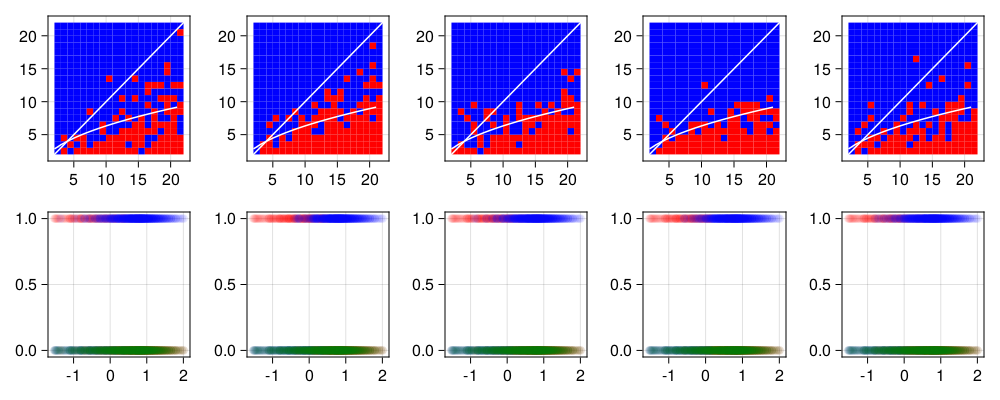

In [18]:
f = Figure(resolution = (1000,400))
thresh = 1e-10

for (i,v) = enumerate([1,5,10,15,20])
    ax = Axis(f[1,i])
    s_mat = mean(λ_mat .< -thresh, dims = 4)[:,:,v,1]
    z_mat = mean(abs.(λ_mat) .< thresh, dims = 4)[:,:,v,1]
    u_mat = mean((λ_mat) .> thresh, dims = 4)[:,:,v,1]
    
    for j = 1:n
        for k = 1:m
            c = RGBf(s_mat[j,k],z_mat[j,k],u_mat[j,k])
            poly!(ax, Rect(k+1, j+1, 1.0,1.0), color = c)
        end
    end

    ablines!(ax, [0], [1], color = "white")
    lines!(ax, M_vec, 2sqrt.(M_vec), color = "white")

    ax = Axis(f[2,i])    
    a = (ones(n) .* sqrt.(M_vec)')
    b = N_vec ./ 2sqrt.(M_vec)'
    c = log.( b)

    scatter!(ax, c[:], s_mat[:], color = ("red", 0.1))
    scatter!(ax, c[:], u_mat[:], color = ("blue", 0.1))
    scatter!(ax, c[:], z_mat[:], color = ("green", 0.1))

end

f

There is a clear relationship between the N/M ratio and stability. the relationship seems to be more like $\frac{N}{\sqrt{M}}$. Increasing connectance seems to reduce stability (with the extra constraint of connected webs)

In [76]:
save("../Results/Figures/size_stability.png", f)

CairoMakie.Screen{IMAGE}


### Connectance 

What is the stabiltiy connectance relationship?

In [ ]:
#size and connectance
Nrep = 1
NC = 200
Nratio = 100
M = 30
r = range(-2,2, length = Nratio)



λ_mat = zeros(Nrep, NC, Nratio)

k = [0]
Threads.@threads for i = 1:Nrep
    
    k[1] += 1
    print("\r", k[1])
    
    for j = 1:NC
        for k = 1:Nratio

            N = Int(floor(exp(r[k]) * sqrt(M)))
            J = zeros(N+M, N+M)
            
            f = true
            com = 0
            l = 0
            while f && l < 1000
                l += 1
                com = rand_com(N, M, j / (NC+1))
                f = !check_connected(com)
            end
            
            sp = MiCRM_stability.get_structural_params(com.U,com.L, com.N, com.M)
            ep = get_exponential_parameters(com.N, com.M)
            p = MiCRM_stability.Parameters(com.N,com.M,sp,ep)      
            
            MiCRM_stability.jacobian!(p, J)
            λ_mat[i,j, k] = get_real(eigen(J).values[end])
        end
    end
end

1

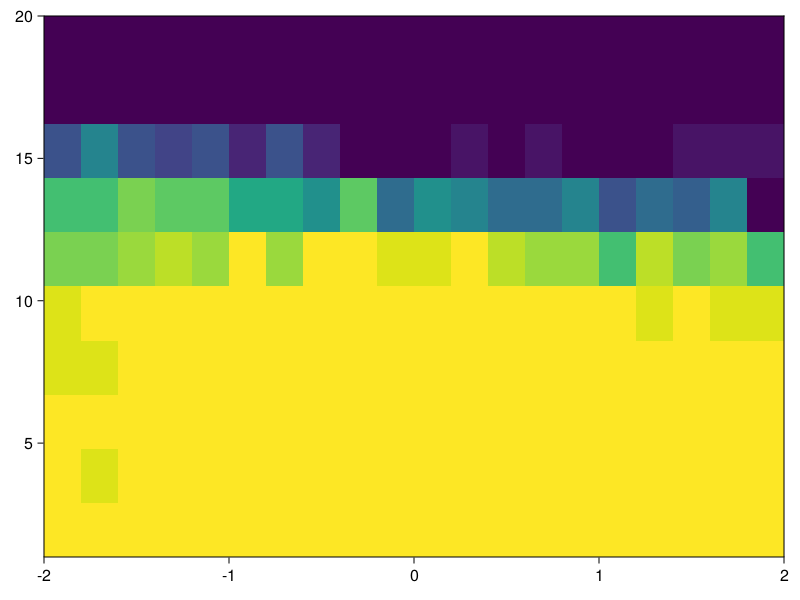

In [77]:
psw = mean(λ_mat .< 0, dims = 1)[1,:,:] 
heatmap(r, 1:NC, psw)

## Random vs niche model

In [838]:
function get_exponential_parameters(N,M)
    σ = 0.05
    gx = ones(N)
    gs = rand(Uniform(1,2)) .+ rand(Uniform(-σ,σ), N)
    gw = zeros(N) #-ones(N) .+ rand(Uniform(-σ,σ), N)
    mx = ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

In [989]:
N = 15
M = 60
Ncom = 100
Nrep = 100
J = zeros(N+M,N+M)

λ_mat = zeros(Ncom, Nrep, 2)
k = [0]

Threads.@threads for i = 1:Ncom
    k[1] += 1
    if k[1] % 10 == 0
        print("\r", k)
    end
    
    
    #generate communites - assert it is connected
    f = true
    c1 = 0
    l = 0
    while f && l < 1000
        l += 1
        c1 = rand_com(N,M, 0.2)
        f = !check_connected(com)
    end

    c1.U .= c1.U .* rand(N,M)
    c1.L .= c1.L .* rand(N,M)
    
    c2 = deepcopy(c1)
    [shuffle!(c2.U,c2.L) for i = 1:1000]
    
    sp1 = MiCRM_stability.get_structural_params(c1.U,c1.L, c1.N, c1.M)
    sp2 = MiCRM_stability.get_structural_params(c2.U,c2.L, c2.N, c2.M)

    for j = 1:Nrep
        #get params and stabiltiy
        ep1 = get_exponential_parameters(c1.N, c1.M)
        p1 = MiCRM_stability.Parameters(c1.N,c1.M,sp1,ep1) 
        MiCRM_stability.jacobian!(p1, J)
        λ_mat[i,j,1] = get_real(eigen(J).values[end])
    
        ep2 = get_exponential_parameters(c2.N, c2.M)
        p2 = MiCRM_stability.Parameters(c2.N,c2.M,sp2,ep2) 
        MiCRM_stability.jacobian!(p2, J)
        λ_mat[i,j,2] = get_real(eigen(J).values[end])
    end
end

print(sum(λ_mat .< 0, dims = (1,2)))

[100][1161;;; 527]

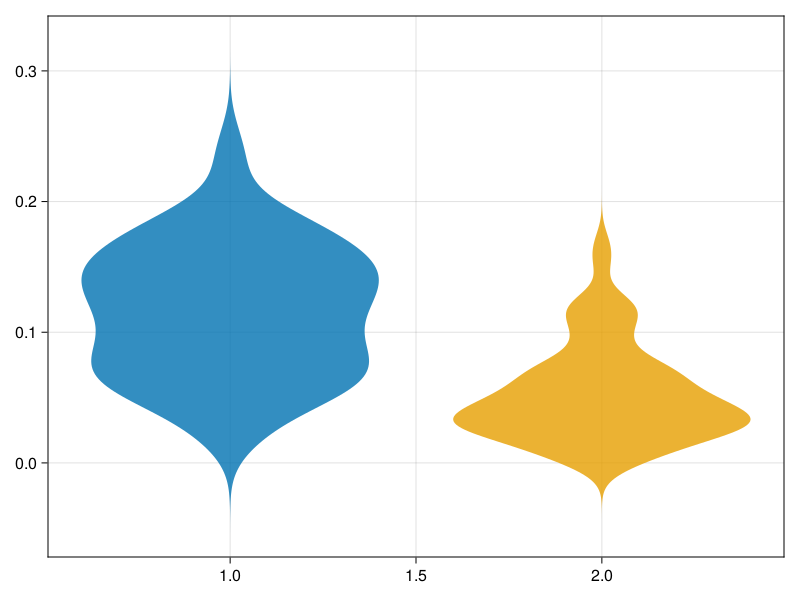

In [990]:
s = mean(λ_mat .< 0, dims = 2)[:,1,:]

# series(s, solid_color = (:black, 0.1))
f,ax = violin(fill(1,Ncom), s[:,1])
violin!(ax, fill(2,Ncom), s[:,2])
f

In [841]:
## Structure

shuffle

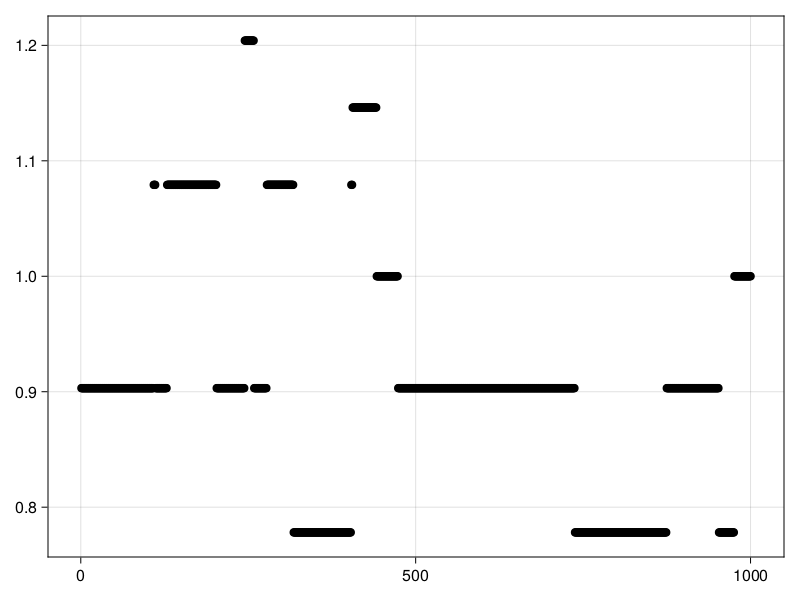

In [991]:
N = 200
M = 400

Random.seed!(2)
f = true
c1 = 0
l = 0
while f 
    l += 1
    c1 = rand_com(N,M, 0.1)
    f = !check_connected(c1)
end
print("shuffle")
c1.U .= c1.U .* rand(N,M)
c1.L .= c1.L .* rand(N,M)
c2 = deepcopy(c1)

Ns = 1000
ps = 1e-5
tl = zeros(Ns)
for i = 1:Ns
    tl[i] = mean_path(c2)
    [shuffle!(c2.U, c2.L) for i = 1:100]
end

plot(log10.(tl))

┌ Warning: Since there are a lot of edges (13854 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/yyvus/src/recipes.jl:526


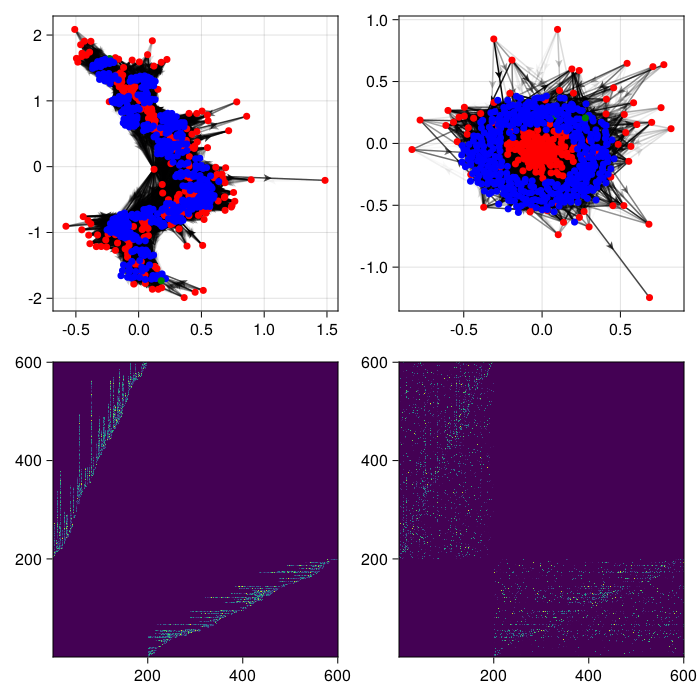

In [992]:
f = Figure(resolution = (700,700))
ax = Axis(f[1,1])
plot_com!(c1, ax)

ax = Axis(f[1,2])
plot_com!(c2, ax)

ax = Axis(f[2,1])
heatmap!(ax, get_A(c1))

ax = Axis(f[2,2])
heatmap!(ax, get_A(c2))

f

## Perturbation minimisation

If stabiltiy is maximised by the tendency to take up increasing resources then there should be a structural effect. In particular we might expect that stabiltiy is maximised when consumers tend to take up resources that are amplified by perturbations. This is effectively a correlation between uptakes and leakages 

Here we test this using a method of generating correlated uptake and leakage matricies. First we construct a covariance matrix giving the variance-covariance structure of the uptake and leakage of all $N$ consumers. 

$$
V = \begin{bmatrix}
    \sigma_{U_1}^2 & \sigma_{U_1, U_2} & \sigma_{U_1,K_1} & \sigma_{U_1,K_2} \\
    \sigma_{U_2,U_1} & \sigma_{U_2}^2 & \sigma_{U_2,K_1} & \sigma_{U_2,K_2} \\
    \sigma_{K_1,U_1} & \sigma_{K_1,U_2} & \sigma_{K_1}^2 & \sigma_{K_1,K_2} \\
    \sigma_{K_2,U_1} & \sigma_{K_2,U_2} & \sigma_{K_2,K_1} & \sigma_{K_2}^2 \\
  \end{bmatrix} = 
  \begin{bmatrix}
    1 & \sigma_{U_1, U_2} & \sigma_{U_1,K_1} & \sigma_{U_1,K_2} \\
    \sigma_{U_2,U_1} & 1 & \sigma_{U_2,K_1} & \sigma_{U_2,K_2} \\
    \sigma_{K_1,U_1} & \sigma_{K_1,U_2} & 1 & \sigma_{K_1,K_2} \\
    \sigma_{K_2,U_1} & \sigma_{K_2,U_2} & \sigma_{K_2,K_1} & 1 \\
  \end{bmatrix}
$$

We set the correlation between uptake and leakage to 0.5 and the self uptake-leakage correlation to 0. The correlation between uptake and leakage is a free parameter with which we can control the degree to which uptakes tend to correlate with the leakage of other species.

In [1061]:
function get_exponential_parameters(N,M)
    σ = 0.05
    gx = 0.5ones(N) .+ rand(Uniform(-σ,σ), N)
    gs = 2ones(N) .+ rand(Uniform(-σ,σ), N)
    gw = zeros(N) 
    mx = 1.2ones(N) .+ rand(Uniform(-σ,σ), N)
    
    fy = ones(N,M)
    hy = -ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)

    iy = zeros(M)
    oy = ones(M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
end

get_exponential_parameters (generic function with 1 method)

49
-0.16282350748040847


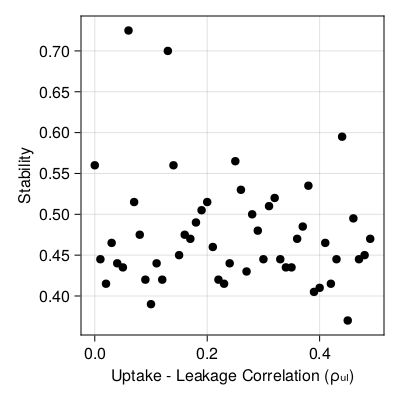

In [1062]:
N = 20
M = 50

Nrep = 200
Ncor = 50

ρ_vec = range(0.0, 0.49, length = Ncor)

J = zeros(N+M, N+M)
res = zeros(Ncor, Nrep)
cor_mat = zeros(Ncor, Nrep)

k = [0]

Threads.@threads for i = 1:Ncor
    print("\r", k[1])
    k[1] += 1
    for j = 1:Nrep
        
        σ = [1.0,0.5,0.5,0.0, ρ_vec[i]]
        f = true
        c = 0
        l = 0
        while f
            l += 1
            c = MiCRM_stability.correlated_rand_model(N,M, σ, 0.2, 0.2)
            f = !check_connected(com)
        end

        sp = MiCRM_stability.get_structural_params(c.U,c.L, c.N, c.M)
        ep = get_exponential_parameters(c.N, c.M)
        p = MiCRM_stability.Parameters(N,M,sp,ep)      
        MiCRM_stability.jacobian!(p, J)

        res[i,j] = get_real(eigen(J).values[end])

        v = 0
        for a = 1:N
            for b = 1:N
                if a != b
                    v += cor(eachrow(c.U)[a] ,eachrow(c.L)[b]) |> mean
                end
            end
        end
        cor_mat[i,j] = v / (N * (N-1))
    end
        
end

f = Figure(resolution = (400,400))
ax = Axis(f[1:2,1], xlabel = "Uptake - Leakage Correlation (ρᵤₗ)", ylabel = "Stability")
scatter!(ax, ρ_vec, mean(res .< -1e-8, dims = 2)[:], color = :black)
println("")
println(cor(ρ_vec, mean(res .< -1e-8, dims = 2)[:]))
f

In [1167]:
#correlated binary variables


In [1168]:
[cor(eachrow(A)[i], eachrow(A)[j]) for i = 1:N, j = 1:N]

10×10 Matrix{Float64}:
  1.0        -0.0597858  -0.0736543  …  -0.205546    0.061242    0.0140591
 -0.0597858   1.0         0.0117073     -0.117272   -0.037547    0.163335
 -0.0736543   0.0117073   1.0           -0.135033    0.0779512   0.026029
 -0.0141748  -0.0540738   0.057735       0.0425243  -0.102869    0.090167
  0.14217    -0.0661922  -0.011399       0.0861976  -0.0142171   0.137671
  0.0790966   0.0283511   0.313518   …  -0.0270733   0.111722    0.192476
 -0.0817198   0.0405694   0.102591      -0.0257473   0.0873335   0.0189891
 -0.205546   -0.117272   -0.135033       1.0        -0.15748    -0.113751
  0.061242   -0.037547    0.0779512     -0.15748     1.0         0.171594
  0.0140591   0.163335    0.026029      -0.113751    0.171594    1.0

In [1157]:
i = 10
j = 9

a = ((sum(V[i,:]) - V[i,i] ) / (N-1))

0.09999999999999999

In [1161]:
b = [cor(A[j,:], A[i,:]) for j = 1:9]

abs.(b .- a)

9-element Vector{Float64}:
 0.19645147753991493
 0.0168896498140388
 0.18627959628145763
 0.16931372582330703
 0.021658986175115177
 0.18627959628145763
 0.17526881720430107
 0.1914505435281224
 0.1914505435281224

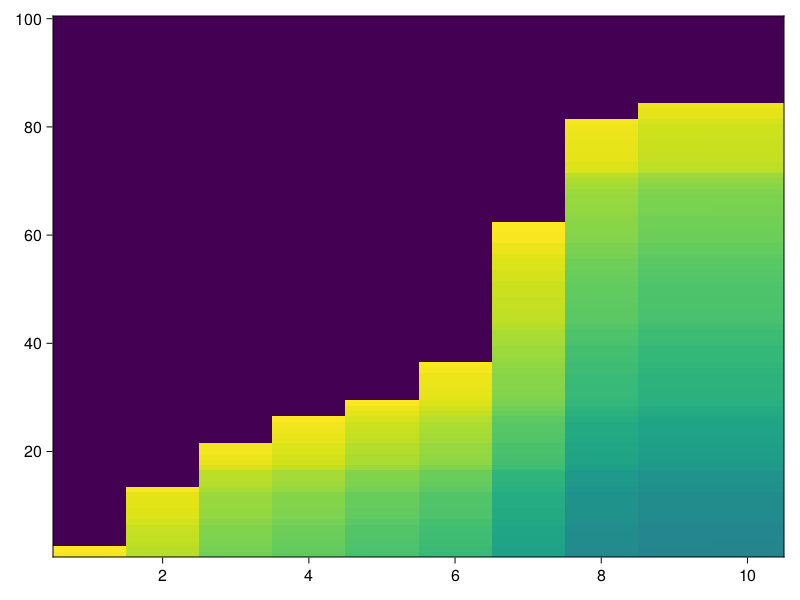

In [248]:
D = 1
N = 10
M = 100

d_euclid(x,y) = sqrt( sum( (x .- y).^2 ) )


ci = [rand(D) for i = 1:N]
ci = ci[sortperm(sum.(ci))]
ca = [rand(D) for i = 1:M]
ca = ca[sortperm(sum.(ca))]

U = fill(0.0,N,M)
    for i = 1:N
        for a = 1:M
            if(sum(ci[i]) > sum(ca[a]))
                U[i,a] =  exp(-(d_euclid(ci[i],ca[a])))
            end
        end

    end

heatmap(U)

In [527]:
using GraphMakie
using Graphs
using NetworkLayout

M = 100

l = fill(Inf,M)
l[1] = 0
S = zeros(M,M)
l_norm = 0

for i = 2:M
    #node probs
    p_l = l[1:(i-1)]
    #sample root node
    ind = sample(1:(i-1) , Weights(p_l))
    #allocate rooting link
    S[ind,i] = 1
    
    #get grand nodes of rooting
    gn_ind = findall(S[:,ind] .> 0)

    if length(gn_ind) > 0
        #get aunts 
        a_ind = mapslices(any, S[gn_ind,:] .> 0, dims = 1)[:] |> findall
        #remove mother and self
        filter!(x -> x != ind, a_ind)
        # println(i," ",ind, a_ind)
        if length(a_ind) > 0 && rand() < 0.1
            ind = sample(a_ind)
            S[ind,i] = 1
        end
    end
   
    # filter!(x -> x != i, a_ind)

    # 
    #     
    #     if(ind == i)
    #         println(i, a_ind)
    #     end
    #     
    # end

    #set new node level
    l[i] = l[findall(S[:,i] .== 1)[1]] + 1
end
S[1,1] = 0

# heatmap(S)

0

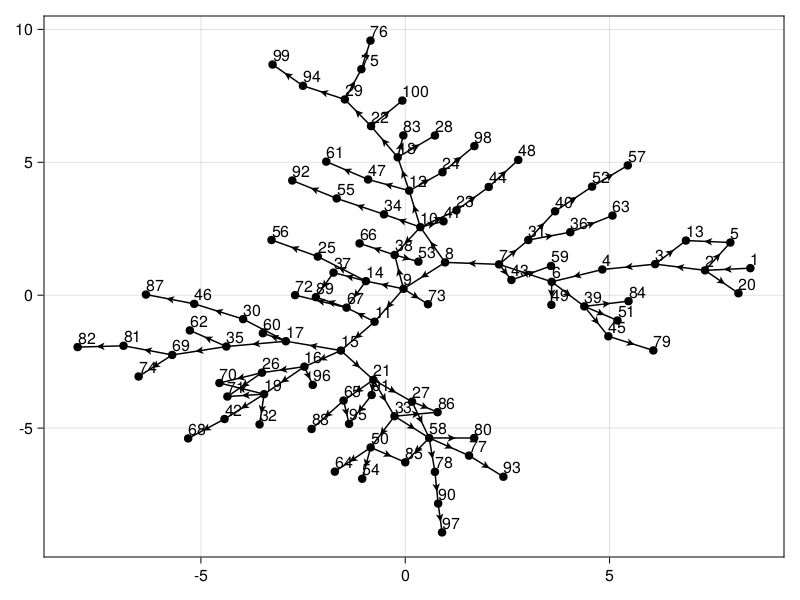

In [528]:
g = SimpleDiGraph(S)
layout = Stress()
f, ax, p = graphplot(g, layout = layout, nlabels=repr.(1:nv(g)))
f

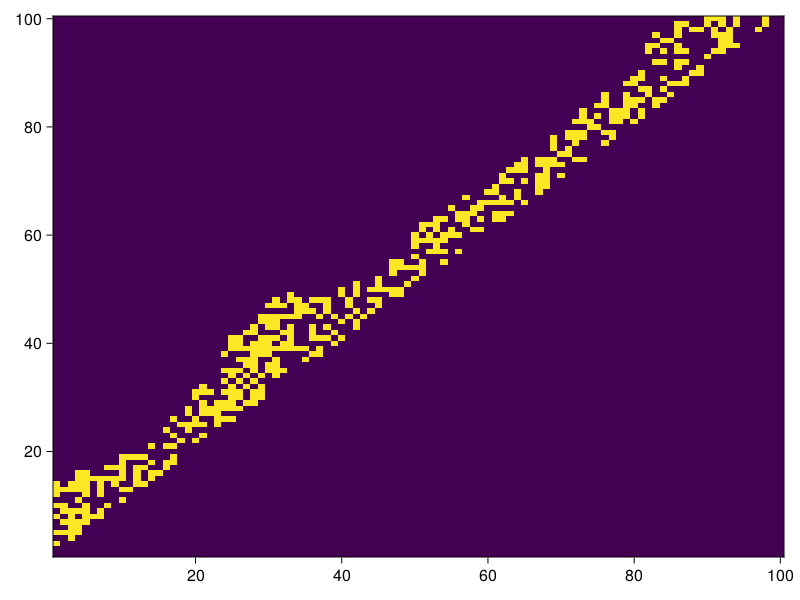

In [767]:
D = 1
N,M = 20, 100

ci = rand(N)
ci = ci[sortperm(sum.(ci))]

ca = rand(M)
ca = ca[sortperm(sum.(ca))]
d = ca' .- ca

#get actual distances
d = map(x -> x > 0 ? x : Inf, d)
#shift by min
L = mapslices(x -> (x .- minimum(x)), d , dims = 2)
L[end,:] .= Inf
#get probs
L = map(x -> !isinf(x) && x < 0.1 ? rand() < 0.5exp(-x)  : 0, L)


heatmap(L)

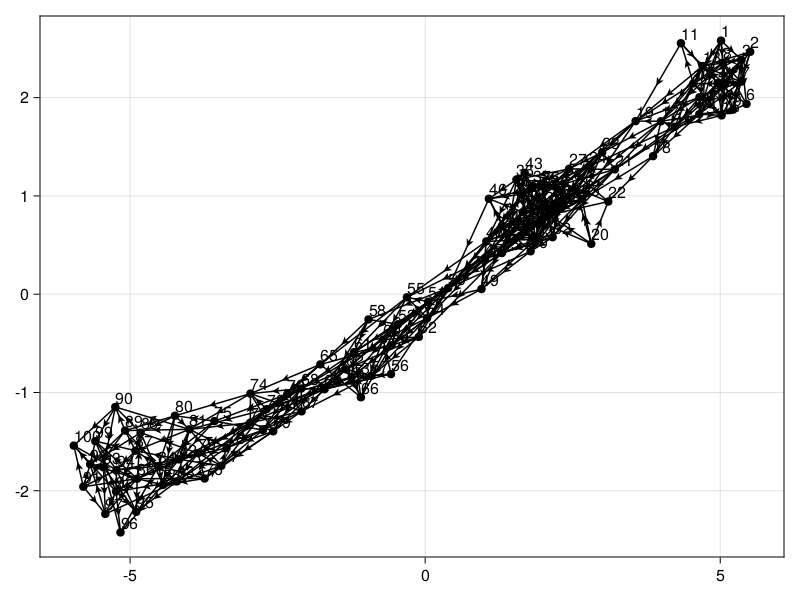

In [768]:
g = SimpleDiGraph(Float64.(L))
layout = Spring(Ptype=Float32)
f, ax, p = graphplot(g, layout = layout, nlabels=repr.(1:nv(g)))
f

In [16]:
function rand_com(N,M)
    ci = rand(N)
    ci = ci[sortperm(sum.(ci))]
    
    ca = rand(M)
    ca = ca[sortperm(sum.(ca))]
    
    d = ci .- ca'
    
    fu(x) = 0.2 > x > 0 ? rand() < exp(-x) : 0
    fl(x) = -0.2 < x < 0 ? rand() < exp(-x) : 0
    
    U = fu.(d)
    L = fl.(d)
    return(MiCRM_stability.Community(N,M,U,L))
end

function shuffle!(U,L)
    N,M = size(U)
    #shuffle pairs
    p1 = (rand(1:N),rand(1:M))
    p2 = (rand(1:N),rand(1:M))
    
    if rand() < 0.5
        tmp = deepcopy(U[p1...])
        U[p1...] = U[p2...]
        U[p2...] = tmp
    else
        tmp = deepcopy(L[p1...])
        L[p1...] = U[p2...]
        L[p2...] = tmp
    end

end

shuffle! (generic function with 1 method)

In [855]:


cmat = [cor(eachrow(U)[i], eachrow(L)[j]) for i = 1:N, j = 1:N]
c1 = mean(cmat)

[shuffle!(U,L) for i = 1:100000]

cmat = [cor(eachrow(U)[i], eachrow(L)[j]) for i = 1:N, j = 1:N]
c2 = mean(cmat)

println(c1, " ", c2)


0.03485802221126133 0.0007588895332597326


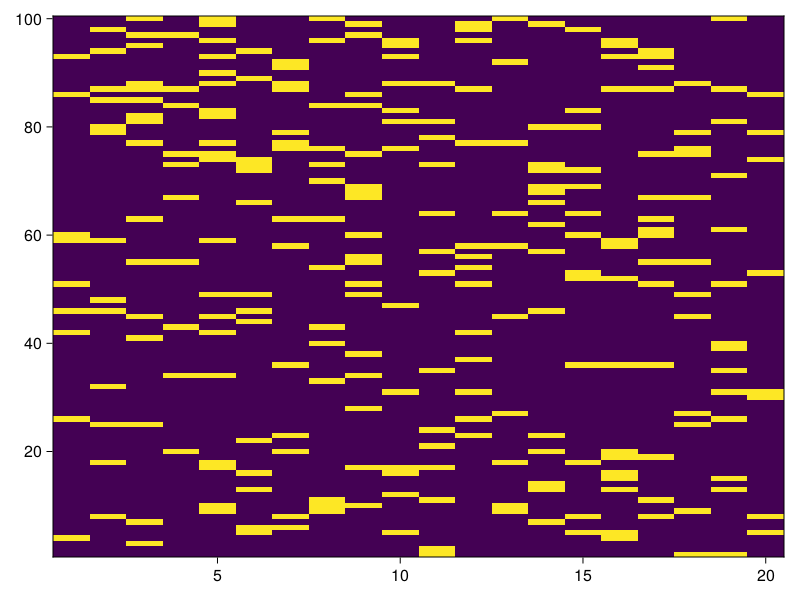

In [856]:
heatmap(U)

In [1032]:
save("../Results/Figures/UL_correlations.png", f)

CairoMakie.Screen{IMAGE}


This is a nice and pretty clear result. Increasing the correlation between uptake and leakages enhances community stability. This fits with the mechanism suggested by the exponential parameters. Communtiy stability is maximised when consumers are able to respond to changes in resource abundance and their uptakes tend to focus on resources most produced by others through metabolic leakage.

\begin{equation}
\rho_{U} \
\rho_{L} \
\rho_{UL}^{intra} \
\rho_{UL}^{inter} \
\end{equation}

## Structural correlations
The correlated model also lets us explore other features of the covariance matrix between microbial consumers and thier uptake/leakage.

First we look at the correlations in uptake and leakage between consumers. High correlations between uptake profiles indicates increasing overlap and is thought to increase competitive pressure. This may be destabilising if overexploitation of resources 

In [93]:
function stab_func(c)
    sp = MiCRM_stability.get_structural_params(c.U,c.L, c.N, c.M)
    ep = MiCRM_stability.get_stable_exp_parameters(c.N, c.M)
    p = MiCRM_stability.Parameters(c.N,c.M,sp,ep)      
    MiCRM_stability.jacobian!(p, J)
end

N = 5
M = 5

Cu = 0.5
Cl = 0.5

Nrep = 2000
Ncor = 20
ρ_vec = range(0.0,0.5, length = Ncor)

J = zeros(N+M, N+M)
res = zeros(Ncor,Ncor, Nrep)

k = [0]

Threads.@threads for i = 1:Ncor
        print("\r", k[1])
    for j = 1:Ncor
        for k = 1:Nrep
                σ = [1.0, ρ_vec[i],ρ_vec[j],0.0,0.0]
                c = MiCRM_stability.correlated_rand_model(N,M,σ, Cu, Cl)
                stab_func(c)
                res[i,j,k] = get_real(eigen(J).values[end])
        end
    end
    k[1] += 1
end

13

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @[39m [90m./[39m[90m[4mboot.jl:479[24m[39m[90m [inlined][39m
      [2] [0m[1mArray[22m
    [90m    @[39m [90m./[39m[90m[4mboot.jl:487[24m[39m[90m [inlined][39m
      [3] [0m[1mzeros[22m
    [90m    @[39m [90m./[39m[90m[4marray.jl:636[24m[39m[90m [inlined][39m
      [4] [0m[1mzeros[22m
    [90m    @[39m [90m./[39m[90m[4marray.jl:632[24m[39m[90m [inlined][39m
      [5] [0m[1meigen![22m[0m[1m([22m[90mA[39m::[0mMatrix[90m{Float64}[39m; [90mpermute[39m::[0mBool, [90mscale[39m::[0mBool, [90msortby[39m::[0mtypeof(LinearAlgebra.eigsortby)[0m[1m)[22m
    [90m    @[39m [32mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.10.0+0.x64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4meigen.jl:155[24m[39m
      [6] [0m[1meigen![22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.10.0+0.x64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4meigen.jl:149[24m[39m[90m [inlined][39m
      [7] [0m[1meigen[22m[0m[1m([22m[90mA[39m::[0mMatrix[90m{Float64}[39m; [90mpermute[39m::[0mBool, [90mscale[39m::[0mBool, [90msortby[39m::[0mtypeof(LinearAlgebra.eigsortby)[0m[1m)[22m
    [90m    @[39m [32mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.10.0+0.x64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4meigen.jl:241[24m[39m
      [8] [0m[1meigen[22m[0m[1m([22m[90mA[39m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m    @[39m [32mLinearAlgebra[39m [90m~/.julia/juliaup/julia-1.10.0+0.x64.apple.darwin14/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4meigen.jl:237[24m[39m
      [9] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mIn[93]:30[24m[39m[90m [inlined][39m
     [10] [0m[1m(::var"#921#threadsfor_fun#346"{var"#921#threadsfor_fun#345#347"{UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:214[24m[39m
     [11] [0m[1m#921#threadsfor_fun[22m
    [90m    @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:181[24m[39m[90m [inlined][39m
     [12] [0m[1m(::Base.Threads.var"#1#2"{var"#921#threadsfor_fun#346"{var"#921#threadsfor_fun#345#347"{UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:153[24m[39m

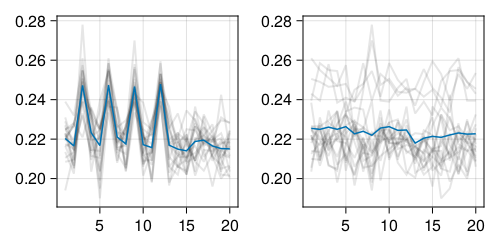

In [81]:
f = Figure(resolution = (500,250))

ax1 = Axis(f[1,1])
series!(ax1, mean(res .< 0, dims = 3)[:,:,1]', solid_color = (:black,0.1))
lines!(ax1, mean(res .< 0, dims = (2,3))[:,1,1])

ax2 = Axis(f[1,2])
series!(ax2, mean(res .< 0, dims = 3)[:,:,1], solid_color = (:black, 0.1))
lines!(ax2, mean(res .< 0, dims = (1,3))[1,:,1])

f

# Empirical Data

In [397]:
#read empirical matricies
C = readdlm("./data/C_mat.csv",',') .> 0
K = readdlm("./data/D_mat.csv",',') .> 0;

N = 30
indx = sample(1:size(C)[1], N, replace = false)

C_sub = C[indx,:]

#shuffle whilst preserving marginal probabiliyties
function get_p_mat(A)
    row_μ = mean(A, dims = 2)[:]
    col_μ = mean(A, dims = 1)[:]
    
    return [(c + r)/2 for r = row_μ, c = col_μ]
end

# function get_exponential_parameters(N,M)
#     σ = 0.1
#     gx = ones(N)
#     gs = 2ones(N)
#     gw = -ones(N)
    
#     mx = 2ones(N)
    
#     fy = ones(N,M)
#     hy = ones(N,M)
    
#     λy = ones(N,M)
#     ωy = ones(N,M)
    
#     iy = ones(M)
#     oy = 2ones(M)

#     return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,iy,oy)
# end

get_p_mat (generic function with 1 method)

In [552]:
Nrep = 10
Nstab = 10

N = 20
M = size(C)[2]

stability = zeros(Nrep,Nstab, 2)
J = 0
C_sub = 0

k = [0]

for r = 1:Nrep
    k[1] += 1
    print(k[1], "\r")

    indx = sample(1:size(C)[1], N, replace = false)
    ind_M = sample(1:size(C)[2], M, replace = false)

    global C_sub = C[indx,ind_M]
    K_sub = K[indx,ind_M]

    s = MiCRM_stability.get_structural_params(C_sub, K_sub, N, M)

    Threads.@threads for st = 1:Nstab
        # print(r, " 1 ", st,"\r")
        e = get_exponential_parameters(N, M)
        p = MiCRM_stability.Parameters(N, M, s, e)
        global J = zeros(N+M, N+M)
        MiCRM_stability.jacobian!(p, J)
        stability[r,st,1] = get_real(eigvals(J)[end]) < 0
    end

    #randomised
    rC = get_p_mat(C_sub) .< rand(N,M)
    rK = get_p_mat(K_sub) .< rand(N,M)
    
    s = MiCRM_stability.get_structural_params(rC, rK,N,M)

    Threads.@threads for st = 1:Nstab
        # print(r, " 2 ", st,"\r")
        e = get_exponential_parameters(N, M)
        p = MiCRM_stability.Parameters(N,M,s,e)  
        J = zeros(N+M,N+M)
        MiCRM_stability.jacobian!(p, J)
        stability[r,st,2] = get_real(eigvals(J)[end]) < 0
    end
end

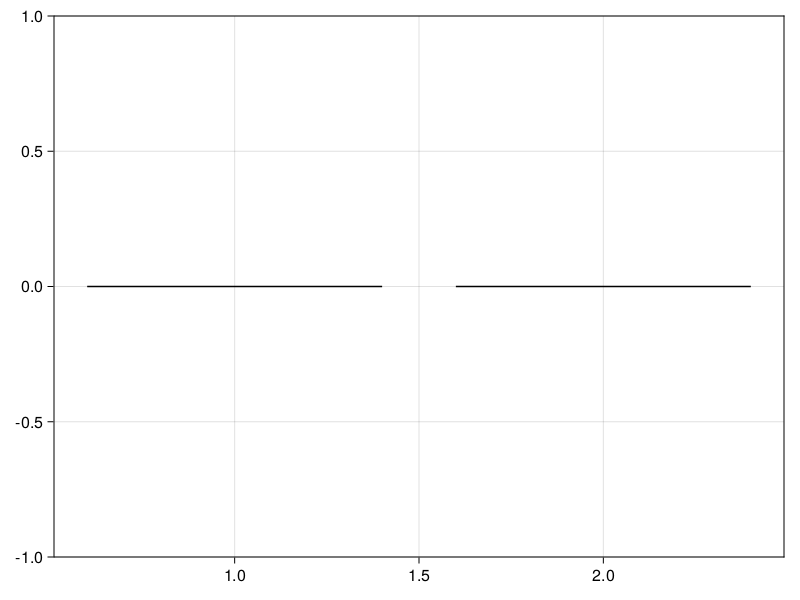

In [553]:
p_stab = mean(stability, dims = (2))[:,1,:]

f,ax = boxplot(ones(Nrep), p_stab[:,1], color = "blue")
boxplot!(ax, 2ones(Nrep), p_stab[:,2], color = "red")

f

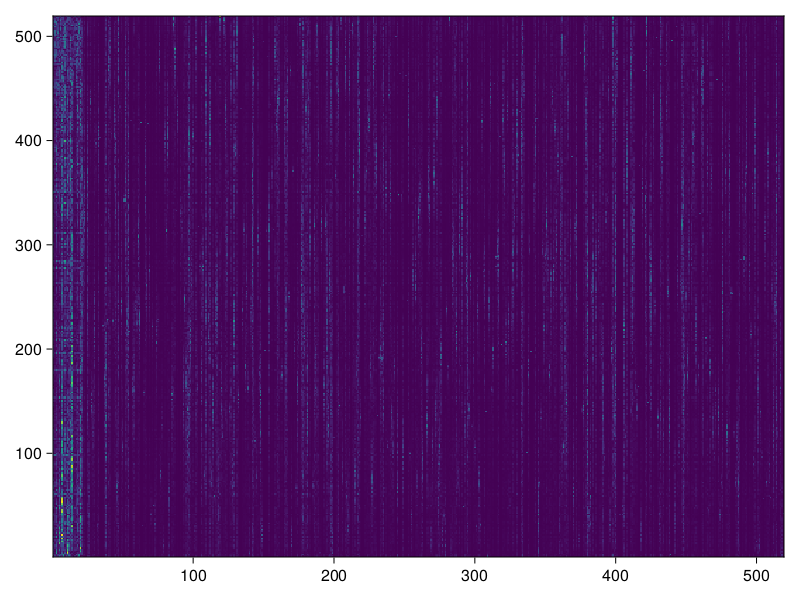

In [572]:
norm.(eigen(J).vectors)


In [7]:
λ = Vector{Eigen}(undef, 1000)

s = MiCRM_stability.get_structural_params(C[indx,to_keep], K[indx,to_keep], N, M)

for i = 1:1000 
    print(i, "\r")
    e = MiCRM_stability.get_exponential_parameters(N,M)
    p = MiCRM_stability.Parameters(N,M,s,e)

    J = zeros(N + M, N + M)
    MiCRM_stability.jacobian!(p, J)

    λ[i] = eigen(J)
end

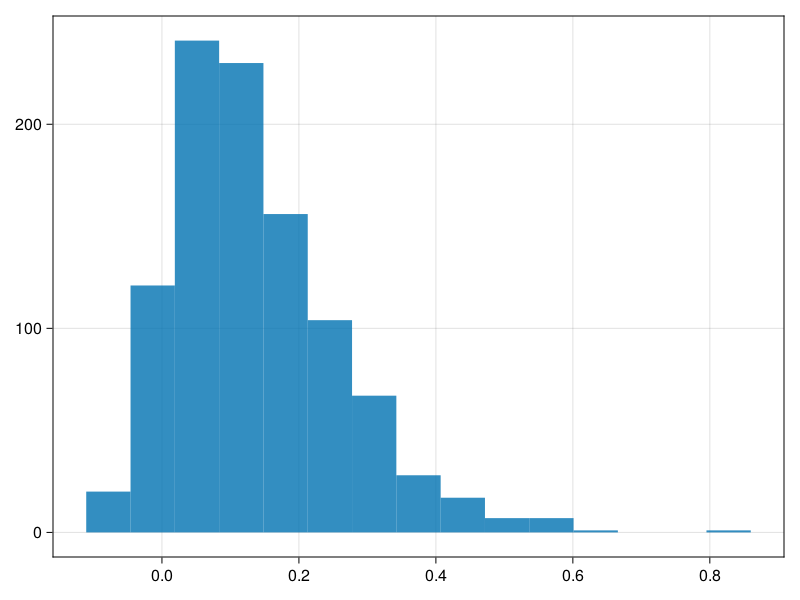

In [8]:
f(x) = isa(x, Complex) ? x.re : x
hist([f(x.values[end]) for x = λ])

# Dimensionality

In [25]:
#struct with an ordering of M resources
mutable struct ordering{T}
    N::Int64
    M::Int64
    D::Int64
    order::T
    A::Matrix{Int64}
    e::Int64
end

#swap i to j on dimension D
function invert!(o::ordering, i::Int64,j::Int64,D::Int64)
    o.order[:,D] .= reverse(o.order[:,D], i, j)
end

function swap!(o::ordering, i::Int64,j::Int64,D::Int64)
    a = o.order[i,D]
    o.order[i,D] = o.order[j,D]
    o.order[j,D] = a
end



function calculate_error!(o::ordering)
    o.e = 0 #clear current error
    sums = zeros(o.M) #to store diet limits
    
    #loop over each species
    for i = 1:o.N
        #clear lims
        sums .= 0

        #loop over dimensions
        for (j,o_D) = enumerate(eachcol(o.order))
            
            #get diet of i in dimension j
            d_i = o_D[A[i,:] .== 1]
            if !isempty(d_i)
                
                #get niche limits
                lims = extrema(d_i)
                #add 1 to resources within limits
                sums .+= lims[1] .<= o_D .<= lims[2]
            end
            
        end
        o.e += (sum(sums .== o.D)) - (sum(A[i,:]))
    end
end

calculate_error! (generic function with 1 method)

In [26]:
N = 10
M = 20
D = 3

#random binary network
A = zeros(Int64, N,M)
A[rand(1:100, 25)] .= 1

#random order
order = hcat([sample(1:M, M, replace = false) for i = 1:D]...);
o = ordering(N,M,D,order,A,N*M)
o.order

20×3 Matrix{Int64}:
 16  13   4
  9   6   2
  3  17   7
  4  12  18
 12   5  17
 15  14  11
 13  18   3
 18   7  12
  5  10   9
 17   8   6
 20   9   5
  2   2  19
  1  19  10
 14  15  14
  8  20  15
  7   3  20
  6  11  13
 10  16   8
 19   1   1
 11   4  16

In [232]:
#GA
struct Population{T}
    N::Int64
    individuals::Vector{T}
    scores::Vector{Int64}
    t::Int64
end

function calculate_fitness!(P::Population)
    for (i,ind) = enumerate(P.individuals)
        calculate_error!(ind)
        P.scores[i] = ind.e
    end
end

function propagate!(P::Population)
    #normalise scores to get probability
    sd = std(P.scores) 
    sd = sd == 0 ? 1 : sd
    z_score = (P.scores .- mean(P.scores)) ./ sd
    p = 1 ./ (1 .+ exp.(10z_score))
    p = p ./ sum(p)
    new = sample(1:P.N, weights(p), P.N)
    P.individuals .= P.individuals[new]
end

function mutate!(P::Population)
    for i = P.individuals
        for D = 1:i.D
            swap!(i, rand(1:i.M), rand(1:i.M), D)
            if rand() < 0.0
                s = rand(1:i.M)
                e = rand(s:i.M)
                invert!(i,s,e,D)
            end
        end
    end
end



mutate! (generic function with 1 method)

In [240]:
N_pop = 100
N = 20
M = 20
D = 10

A = zeros(Int64, N,M)
A[rand(N,M) .> 0.5] .= 1

order = [hcat([sample(1:M, M, replace = false) for i = 1:D]...) for j = 1:N_pop]
individuals = [ordering(N,M,D,order[i],A,10) for i = 1:N_pop]

P = Population(N_pop, individuals, ones(Int64, N_pop), 0)
calculate_fitness!(P)

res = Vector{Population}(undef, 101)
res[1] = deepcopy(P)

for i = 1:100
    propagate!(P)
    mutate!(P)
    calculate_fitness!(P)
    res[i+1] = deepcopy(P)

    print(i, "\r")
end

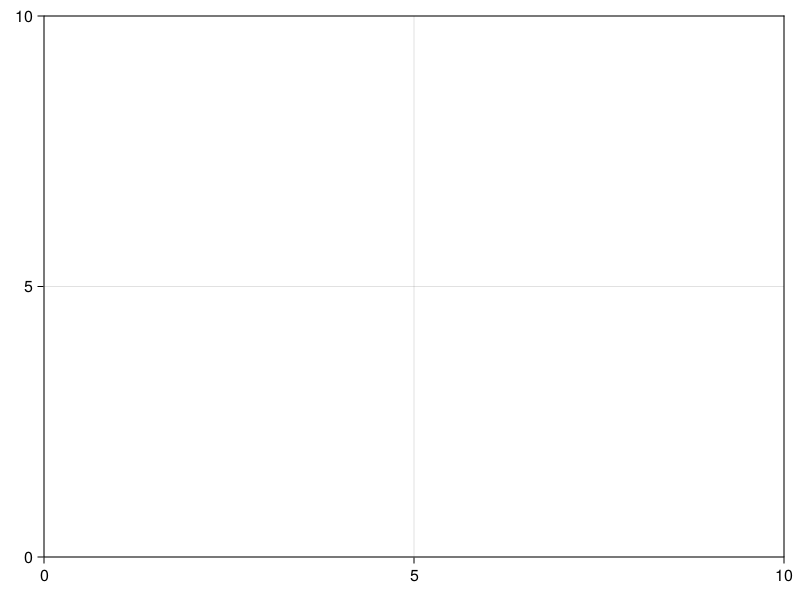

In [247]:
x = res[20]
z = (x.scores .- mean(x.scores)) ./ std(x.scores)
p = 1 ./ (1 .+ exp.(10z))

scatter(x.scores,p)

In [122]:
calculate_fitness!(P)
std(P.scores)

0.0

In [542]:
C_sub = C[1:10,1:10]

#calculate error
#D1
e = 0

order = [sample((1:10), 10, replace = false) for i = 1:2]

for o = order
    for i = o
        f_ind = findfirst(C_sub[i,o])
        l_ind = findlast(C_sub[i,o])
    
        if f_ind != l_ind
        s = l_ind - f_ind - sum(C_sub[i,f_ind:l_ind]) + 1
            e += s
        end
    end
end
e

56

In [413]:
order

2-element Vector{Vector{Int64}}:
 [7, 8, 9, 2, 1, 4, 10, 6, 5, 3]
 [7, 5, 10, 1, 3, 4, 8, 6, 9, 2]

In [3]:
#test 
#construct uptake, leakage and effective leakage
U = fu(nC,nR,f_guassian)
U[:,end] .= 0.0

# U = rand(N,M)

L = fl(nC,nR,f_guassian)
L = 0.3 * L ./ (norm.(eachrow(L), 1))
L[isnan.(L)] .= 0.0

K = U * L;

f = Figure(resolution = (1000,300))
ax = [Axis(f[1,i]) for i = 1:3]

[heatmap!(ax[i], m) for (i,m) = enumerate([U,L,K])]

f

LoadError: UndefVarError: `fu` not defined

In [8]:
N,M = size(rand(2,2))

(2, 2)

In [279]:
function get_structural_params(U,K)
    N,M = size(U)
    #structural
    α = ones(N)
    β = ones(M)
    
    #branching
    ρ = zeros(N)
    ρ[sum(K,dims=1)[:] .== 0] .= 1.0
    ρ̃ = 1 .- ρ
    
    σ = zeros(N)
    σ[sum(U,dims=1)[:] .== 0] .= 1.0
    σ̃ = 1 .- σ
    
    γ = U ./ (norm.(eachcol(U), 1)')
    η = K ./ (norm.(eachcol(K), 1)')
    χ = U ./ (norm.(eachrow(U), 1))
    ϕ = K ./ (norm.(eachrow(K), 1))
    
    γ[isnan.(γ)] .= 0.0 
    η[isnan.(η)] .= 0.0 
    χ[isnan.(χ)] .= 0.0 
    ϕ[isnan.(ϕ)] .= 0.0 

    return MiCRM_stability.structural_params(α,β,ρ,ρ̃,σ,σ̃,γ,η,χ,ϕ);
end

get_structural_params (generic function with 1 method)

In [262]:
function get_exponential_parameters(N,M)
    gx = (0.5) .+ (rand(N) / 2)
    gs = (0.5) .+ (rand(N))
    gw = -(0.5) .+ (rand(N))
    
    mx = ones(N)
    
    fy = ones(N,M) .+ rand(Normal(0,0.1), (N,M))
    hy = ones(N,M)
    
    λy = zeros(N,M)
    ωy = zeros(N,M)
    θy = zeros(N,M,M)
    
    iy = (0.5) .+ (rand(M) / 2)
    oy = (0.5) .+ (rand(M) / 2)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,ωy,θy,iy,oy)
end

In [263]:
p = MiCRM_stability.Parameters(N,M,s,e);

J = zeros(N + M, N+M)
MiCRM_stability.jacobian!(p,J)

CC = J[1:N , 1:N] 
CR = J[1:N , N+1:end] 
RC = J[N+1:end, 1:N]
RR = J[N+1:end, N+1:end]

mean_no_zero(x) = mean(x[x .!= 0.0])

mean_no_zero.([CC,CR,RC,RR])

4-element Vector{Float64}:
 -0.2544736575424741
  0.010540030178867104
  5.035397068794012e-6
 -6.157722753269433e-5

In [264]:
CR

100×100 Matrix{Float64}:
 0.032776    0.030143    0.031642    …  -0.000137642  -0.000130183
 0.0379548   0.0375843   0.0366442      -0.000136422  -0.000129399
 0.0340495   0.0384692   0.0394199       0.000131644   0.000116517
 0.0262613   0.0239471   0.0266606       0.000207333   0.000189435
 0.0196623   0.0208389   0.0269363      -0.000182148  -0.000175596
 0.0148216   0.0179108   0.015716    …  -0.000105979  -0.000102115
 0.0191568   0.0178457   0.019923        0.000201306   0.000183354
 0.0302232   0.0366589   0.0382109       1.8671e-5     8.8545e-6
 0.0268096   0.0269442   0.0273539      -0.000236863  -0.000232532
 0.0203775   0.0207081   0.0203777      -0.000435159  -0.00041834
 0.0147859   0.0115642   0.0160489   …   0.000289767   0.000261106
 0.0229267   0.0228852   0.0198779       0.000156477   0.000129874
 0.0125274   0.0113621   0.0134744       0.000103099   8.74567e-5
 ⋮                                   ⋱                
 9.00926e-6  8.36211e-6  9.49688e-6      0.0198889   

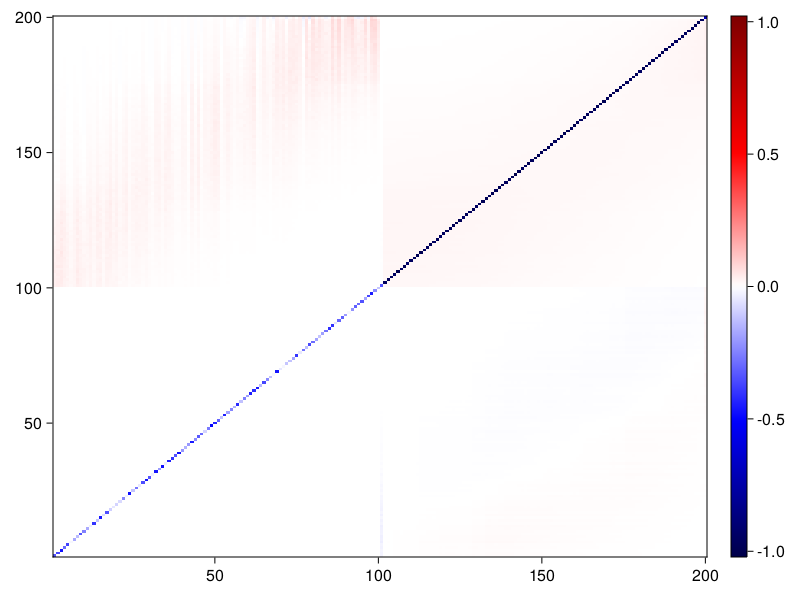

In [265]:
crange(x) = (-maximum(abs.(x)), maximum(abs.(x)))
f,ax,p = heatmap(J, colormap = :seismic, colorrange = crange(J[:]))
Colorbar(f[1,2], colorrange = crange(J[:]), colormap = :seismic)
f

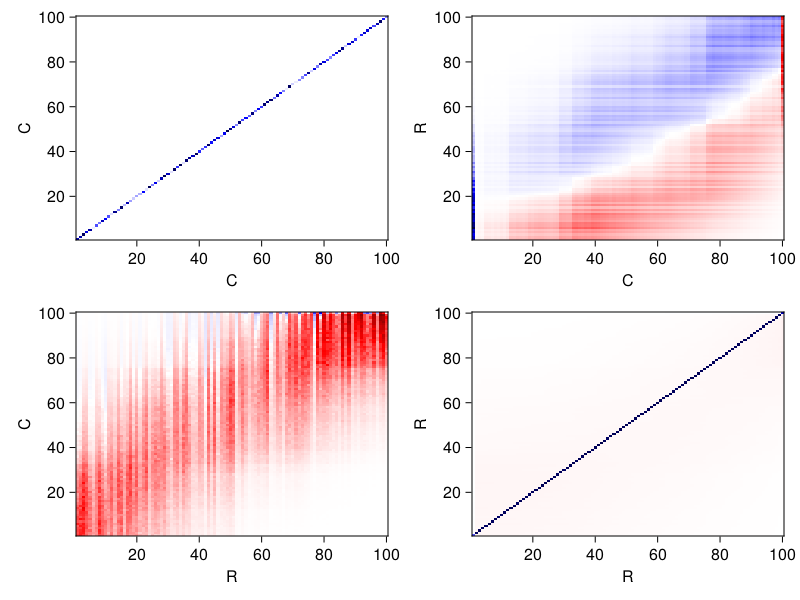

In [266]:
f = Figure()

label = ["C","R"]

ax = [Axis(f[i,j], xlabel = label[i], ylabel = label[j]) for i = 1:2, j = 1:2]

[heatmap!(ax[i], m, colormap = :seismic, colorrange = crange(m[:])) for (i,m) = enumerate([CC,CR,RC,RR])]

f

-0.010418953791251467 + 0.10467619402483183im

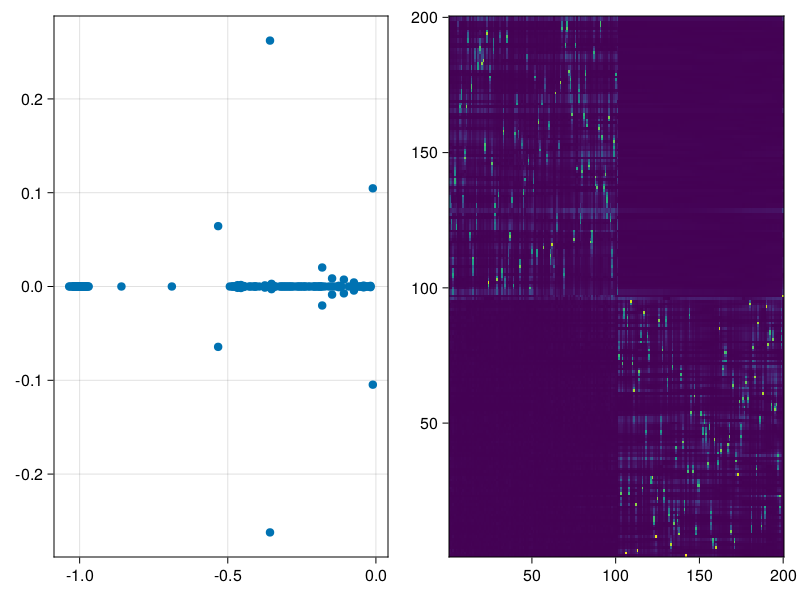

In [276]:
λ = eigen(J)

print(λ.values[end])

r = [x.re for x = λ.values]
i = [x.im for x = λ.values]

f,ax = scatter(r,i)
heatmap!(Axis(f[1,2]), norm.(λ.vectors[:,:]))
f

In [174]:
J[150,150]

-0.968747033309227

In [155]:
a = 50
b = 50

p.s.ρ[a] * p.e.iy[a] - p.s.σ[a] * p.e.oy[a]

0.0

In [167]:
sigma = [p.s.σ̃[a] * p.s.γ[i,a] * (p.e.fy[i,a] * (p.s.χ[i,a] * (p.e.gs[i] - 1) +1) + 
                    p.e.gw[i] * p.s.ϕ[i,a] * p.e.hy[i,a]) for i = 1:N]

sum(sigma)

1.0038254017974517

In [169]:
rho = [p.s.ρ̃[a] * p.s.η[i,a] * (p.e.gs[i] * p.s.χ[i,a] * p.e.fy[i,a] + p.e.gw[i] * p.s.ϕ[i,a] * p.e.hy[i,a] + 
        p.e.λy[i,a] + p.e.θy[i,a,a]) for i = 1:N]

sum(rho)

2.0186015914172235

In [170]:
K[a,b]

0.24206729057248955